In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/Users/arden/opt/anaconda3/envs/handson/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


이미지가 70,000개 있고 각 이미지는 784개의 특성이 있음. 이미지가 28*28 픽셀이기 때문. 개개의 특성은 단순희 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄

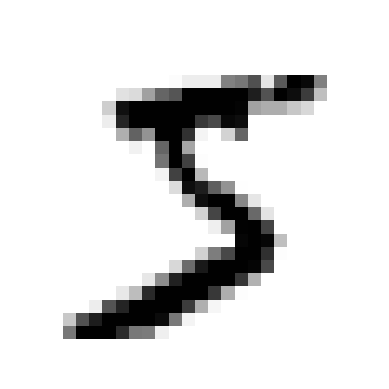

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
# 문자열을 정수로 변환
import numpy as np
y = y.astype(np.uint8)

- int는 음수와 양수를 아우르는 정수형
- unit는 0을 포함한 양수, 부호 없는 정수
- int나 uint 뒤에 오는 숫자는 bit의 개수를 의미함. 예를 들어 숫자가 8이면 2^8개만큼의 정수를 표현하는 것이 가능

In [6]:
# 훈련셋, 테스트셋 구분
# MNIST 데이터셋은 이미 훈련셋, 테스트셋이 나눠져있음
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진분류기 훈련

In [7]:
# 숫자 5만 식별해보자
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### 확률적 경사 하강법(SGD)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

분류기는 some_digit의 이미지가 5를 나타낸다고 추측함(true)

### 성능 측정
#### 교차검증

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # SGD분류기 모델만 복사

    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


### 오차행렬
분류기의 성능을 평가하는 더 좋은 방법은 오차행렬이다.  
cross_val_predict() 함수는 K겹 교차검증을 수행하나 평가점수를 반환하지 않고 각 테스트 폴트에서 얻은 예측을 반환한다. 오차행렬을 위해서는 라벨값이 필요한데 테스트셋을 사용할 수 없기 때문에 cross_cal_predict()를 사용한다. 

In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### 정밀도와 재현율

In [17]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [18]:
# F1점수: 정밀도와 재현율의 조화평균
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846